# Accessing ITS_LIVE data via S3 bucket

This notebook will demonstrate how to access cloud-hosted Inter-mission Time Series of Land Ice Velocity and Elevation ([ITS_LIVE](https://its-live.jpl.nasa.gov/#access)) data from AWS S3 buckets. Here you will find examples of how to successfully access cloud-hosted data as well as some common errors and issues you may run into along the way, what they mean, and how to resolve them. 

*Learning goals:*
- accessing data stored in S3 buckets 

In [2]:
import geopandas as gpd
import os
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from shapely.geometry import Polygon
from shapely.geometry import Point
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy
import cartopy.feature as cfeature
import json
import s3fs

%config InlineBackend.figure_format='retina'


## ITS_LIVE data cube catalog

The ITS_LIVE project details a number of data access options on their [website](https://its-live.jpl.nasa.gov/#access). Here, we will be accessing ITS_LIVE data in the form of `zarr` data cubes that are stored in **s3 buckets** hosted by Amazon Web Services (AWS). 

Let's begin by looking at the [GeoJSON Data Cubes Catalog](https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json). 
This catalog contains spatial information and properties of ITS_LIVE data cubes as well as the url used to access each cube. Let's take a look at the entry for a single data cube and the information that it contains:

![itslive_info](images/screengrab_itslive_catalog_entry.png)

The top portion of the picture shows the spatial extent of the data cube in lat/lon units. Below that, we have properties such as the epsg code of the coordinate reference system, the spatial footprint in projected units and the url of the zarr object. 

Let's take a look at the url more in-depth: 

![itslive_url](images/itslive_url.png)

From this link we can see that we are looking at its_live data located in an s3 bucket hosted by amazon AWS. We cans see that we're looking in the data cube directory and what seems to be version 2. The next bit gives us information about the global location of the cube (N40E080). The actual file name `ITS_LIVE_vel_EPSG32645_G0120_X250000_Y4750000.zarr` tells us that we are looking at ice velocity data (its_live also has elevation data), in the CRS associated with EPSG 32645 (this code indicates UTM zone 45N). X250000_Y4750000 tells us more about the spatial footprint of the datacube within the UTM zone. 

**NOTE**
This catalog provides http links to the zarr objects. To successfully point to the objects that we're looking for in s3 buckets, we need to make a few changes to the links:
- replace 'http' with 's3'
- delete '.s3.amazonaws.com' </br>

so the correct url should read: </br>

    `s3://its-live-data/datacubes/v02/N40E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y4750000.zarr`


## Accessing ITS_LIVE data from python

We've found the url associated with the tile we want to access, let's try to open the data cube using `xarray`:

In [3]:
url1 = 's3://its-live-data/datacubes/v02/N40E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y4750000.zarr'
dc1 = xr.open_dataset(url1, engine = 'zarr')

ConnectTimeoutError: Connect timeout on endpoint URL: "http://169.254.169.254/latest/api/token"

As you can see, this doesn't quite work. We need to specify a bit more information for xarray to be able to access and load the data cube. 

- Specifically we need to specify `storage_options={"anon": True}`.
    - This is a `backend_kwarg` relating to how we are interacting with the AWS S3 bucket. You can find more information [here](https://docs.xarray.dev/en/stable/user-guide/io.html#cloud-storage-buckets).
- I set `chunks="auto"` which introduces [dask](https://www.dask.org/) into our workflow.

In [4]:
dc1 = xr.open_dataset(url1, engine= 'zarr', chunks="auto",
                                    storage_options = {'anon':True})

In [5]:
dc1

<xarray.Dataset>
Dimensions:                    (mid_date: 15725, y: 834, x: 833)
Coordinates:
  * mid_date                   (mid_date) datetime64[ns] 2020-02-03T17:26:57....
  * x                          (x) float64 2.001e+05 2.002e+05 ... 2.999e+05
  * y                          (y) float64 4.8e+06 4.8e+06 ... 4.7e+06 4.7e+06
Data variables: (12/54)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(15725,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(15725,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(15725,), meta=np.ndarray>
    chip_size_height           (mid_date, y, x) float32 dask.array<chunksize=(15725, 40, 40), meta=np.ndarray>
    chip_size_width            (mid_date, y, x) float32 dask.array<chunksize=(15725, 40, 40), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(15725,), meta=np.ndarray>
    ...                         ...
    vy_error_mask              (mid_date) float64 dask.array<chunksize=(15725,), meta=np.ndarray>
    vy_error_modeled           (mid_date) float64 dask.array<chunksize=(15725,), meta=np.ndarray>
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(15725,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(15725,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(15725,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(15725,), meta=np.ndarray>
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               09-Jun-2022 04:57:12
    date_updated:               09-Jun-2022 04:57:12
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N40E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N40E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

This one worked! Let's stop here and define a function that we can use for a quick view of this data.


In [6]:
def get_bounds_polygon(input_xr):
    
    xmin = input_xr.coords['x'].data.min()
    xmax = input_xr.coords['x'].data.max()

    ymin = input_xr.coords['y'].data.min()
    ymax = input_xr.coords['y'].data.max()

    pts_ls = [(xmin, ymin), (xmax, ymin),(xmax, ymax), (xmin, ymax), (xmin, ymin)]

    crs = f"epsg:{input_xr.mapping.spatial_epsg}"

    polygon_geom = Polygon(pts_ls)
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom]) 
    
    return polygon
    
    
def get_bbox_single(input_xr):
    
    '''Takes input xr object (from itslive data cube), plots a quick map of the footprint. 
    currently only working for granules in crs epsg 32645'''

    
    polygon = get_bounds_polygon(input_xr).to_crs('epsg:4326')
    bounds = polygon.total_bounds
    bounds_format = [bounds[0]-15, bounds[2]+15, bounds[1]-15, bounds[3]+15]

    states_provinces = cfeature.NaturalEarthFeature(
        category = 'cultural',
        name = 'admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'
    )

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = ccrs.PlateCarree())
    ax.stock_img()
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(states_provinces)

    ax.set_extent(bounds_format, crs = ccrs.PlateCarree())

    polygon.plot(ax=ax, facecolor = 'none', edgecolor='red', lw=1.);




Let's also write a quick function for reading in s3 objects from http urls. This will come in handy when we're trying to test multiple urls

In [7]:
def read_in_s3(http_url, chunks = 'auto'):
    s3_url = http_url.replace('http','s3')
    s3_url = s3_url.replace('.s3.amazonaws.com','')

    datacube = xr.open_dataset(s3_url, engine = 'zarr',
                                storage_options={'anon':True},
                                chunks = chunks)

    return datacube

Now let's take a look at the cube we've already read in:

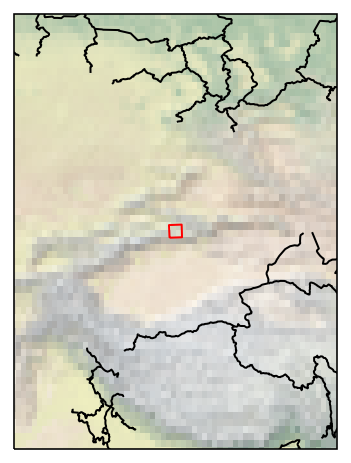

In [8]:
get_bbox_single(dc1)

Now we can see where this granule lies. 

Let's try a url that we know won't work. Sometimes data cubes are moved around within the cloud repositories and it is helpful to know the error that arises in this situation: 

In [9]:
#this url doesn't work
url2 = 'http://its-live-data.s3.amazonaws.com/datacubes/v02/wrong_url_here.zarr'
dc2 = read_in_s3(url2)

/var/folders/y9/k06gyzdx25z64l_tdt_q2xv9s680sz/T/ipykernel_47184/4225930199.py:5: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  datacube = xr.open_dataset(s3_url, engine = 'zarr',


GroupNotFoundError: group not found at path ''

You can see we have a `NoSuchKey` error and then finally a `GroupNotFoundError`, these tell us that the issue with the code in the above cell was that the url was pointing to a location in the s3 bucket that did not contain the specified data cube. 

## Searching ITS_LIVE catalog

Let's take a look at how we could search the ITS_LIVE data cube catalog for the data that we're interested in. There are many ways to do this, this is just one example. 

First, we will read in the catalog geojson file:

In [10]:
import urllib.request
with urllib.request.urlopen('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json') as url:
    itslive_catalog = json.loads(url.read().decode())
itslive_catalog.keys()

dict_keys(['type', 'features'])

In python, the json object has the form of nested dictionaries that contain information about all of the ITS_LIVE datacubes. 

Here we'll show two options for filtering the catalog: 
1. one for selecting granules that contain a specific point, and 
2. one that returns all granules within a single UTM zone (specified by epsg code).  This will let us take stock of the spatial coverage of data cubes located at **working urls** within a certain UTM zone. 

You could easily tweak these functions (or write your own!) to select granules based on different properties. Play around with the `itslive_catalog` object to become more familiar with the data it contains and different options for indexing.

### Selecting data cubes by UTM zone

In [11]:
import s3fs
fs  = s3fs.S3FileSystem(anon=True)
fs

In [27]:
def find_granules_by_zone(input_dict, epsg_code):
    '''This function takes a dictionary (itslive catalog geojson) and a epsg code referencing region of interest. 
    returns list of urls corresponding to datacubes stored in s3 buckets where links *exist*'''
    fs = s3fs.S3FileSystem(anon=True)
    url_ls = []
    for granule in input_dict['features']:
        props = granule['properties']
        if props['epsg'] == epsg_code:
            http_url = props['zarr_url']
            s3_url = http_url.replace('http','s3').replace('.s3.amazonaws.com','')

            # check that the url works.
            url_ls = [s3_url for x in input_dict if fs.lexists(s3_url) == True]
        else: 
            pass

    return url_ls
    

In [28]:
granule_ls_32645 = find_granules_by_zone(itslive_catalog, '32645')
granule_ls_32645


[]

If we wanted to look at the spatial extent of all of the data cubes pointed to in the above list, we could use the `get_bbox_group()` function, but we'd first need to read in the data cubes at the urls as `xr.Datasets`

In [ ]:
dc_ls = [read_in_s3(x) for x in granule_ls_32645]

This function returns a list of xarray objects that correspond to all of the zarr urls for that region that were able to be successfully accessed.

Let's write a function to visualize the coverage:

In [ ]:
def get_bbox_group(input_ls, bounds = [-180, 180, -90, 90]): 
    
    '''plots the spatial extents of a list of datacubes'''
    
    poly_ls = [get_bounds_polygon(xr_obj).to_crs('epsg:32645') for xr_obj in input_ls]

    bounds_format = [bounds[0], bounds[1], bounds[2], bounds[3]]
        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = ccrs.PlateCarree())
    ax.stock_img()
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent(bounds_format, crs = ccrs.PlateCarree())
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.left_labels = False
    gl.xlines = False
    gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'gray'}
    gl.xlabel_style = {'color': 'black'}

    for polygon in poly_ls:
            
        polygon.plot(ax=ax, facecolor='none', edgecolor='red', lw=1.);


In [ ]:
get_bbox_group(dc_ls)

Let's take a closer look at the region of interest, we can do that by specifying bounds when we call the function

In [ ]:
get_bbox_group(dc_ls, bounds=[70, 98, 20, 60])

## Selecting granules by a single point

In [ ]:
def find_granule_by_point(input_dict, input_point): #[lon,lat]
    '''Takes an inputu dictionary (a geojson catalog) and a point to represent AOI.
    this returns a list of the s3 urls corresponding to zarr datacubes whose footprint covers the AOI'''
    
    target_granule_urls = []
    
    point_geom = Point(input_point[0], input_point[1])
    point_gdf = gpd.GeoDataFrame(crs='epsg:4326', geometry = [point_geom])
    for granule in input_dict['features']:
        
        bbox_ls = granule['geometry']['coordinates'][0]
        bbox_geom = Polygon(bbox_ls)
        bbox_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry = [bbox_geom])
        
        if bbox_gdf.contains(point_gdf).all() == True:
            target_granule_urls.append(granule['properties']['zarr_url'])
        else:
            pass
    return target_granule_urls




In [ ]:
url_ls = find_granule_by_point(itslive_catalog, [86.7, 28.07])


Great, this function returned a single url corresponding to the data cube covering the point we supplied

In [ ]:
url_ls

Let's use the `read_in_s3` function we defined to open the datacube as an `xarray.Dataset`

In [ ]:
dc1 = read_in_s3(url_ls[0])

and then the `get_bbox_single` function to take a look at the footprint:

In [ ]:
get_bbox_single(dc1)

Great, now we know how to access the its_live data cubes for a given region as well as at a specific point.

Let's take a quick first look at this data cube. The next notebooks will go into more examples of inspecting and working with this data

In [ ]:
dc1

In [ ]:
dc1.v.mean(dim = 'mid_date').plot();

The above plot shows the mean of the magnitude of velocity variable along the time dimension. It looks like the footprint we're viewing has glaciated terrain in the southern region as well as non-glaciated terrain in the northern region. The rest of the notebooks in this chapter will demonstrate how to subset this spatially-large data object to specific areas of interest.